### setup and load

In [1]:
!pip install --upgrade "kaleido==0.1.*"

  Using cached kaleido-0.1.0-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached kaleido-0.1.0-py2.py3-none-manylinux1_x86_64.whl (74.6 MB)


In [2]:
import bisect
import plotly
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import seaborn as sns
from tqdm.notebook import tqdm
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import shapely
from shapely.geometry import Point
import plotly.io as pio
pio.kaleido.scope.default_format = "png"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!rm -rf rostrud_pipeline

In [8]:
!git clone https://github.com/tha-rc/rostrud_pipeline
!git clone https://github.com/hairymax/offline_russia_plotly

Cloning into 'rostrud_pipeline'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 391 (delta 6), reused 0 (delta 0), pack-reused 374
Receiving objects: 100% (391/391), 7.94 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (233/233), done.
fatal: destination path 'offline_russia_plotly' already exists and is not an empty directory.


In [4]:
class mapFigure(go.Figure):
    def __init__(self, # дефолтные параметры plotly
        data=None, layout=None, frames=None, skip_invalid=False, regions=None,
        **kwargs # аргументы (см. документацию к plotly.graph_objects.Figure())
    ):
        # создаём plotlу фигуру с дефолтными параметрами
        REGIONS = regions
        super().__init__(data, layout, frames, skip_invalid, **kwargs)

        # прорисовка регионов
        #if not isinstance(REGIONS, pd.DataFrame):
        #  REGIONS = pd.read_parquet("offline_russia_plotly/data/russia_regions.parquet")
        #  REGIONS.loc[REGIONS["region"] == "Ханты-Мансийский автономный округ — Югра"] = "Ханты-Мансийский автономный округ - Югра"
        #  REGIONS.loc[REGIONS["region"] == "Республика Северная Осетия — Алания"] = "Республика Северная Осетия-Алания"
        #  REGIONS.loc[REGIONS["region"] == "Москва"] = "г. Москва"
        #  REGIONS.loc[REGIONS["region"] == "Санкт-Петербург"] = "г. Санкт-Петербург"
        for i, r in REGIONS.iterrows():
            self.add_trace(go.Scatter(x=r.x, y=r.y,
                                      name=str(r.region),
                                      text=str(r.region),
                                      hoverinfo="text",
                                      line_color='grey',
                                      fill='toself',
                                      line_width=1,
                                      #fillcolor='lightblue',
                                      fillcolor=f"rgb({np.log(r['n']+1) * 250 + 80}, 100, 100)",
                                      showlegend=False
            ))

        # не отображать оси, уравнять масштаб по осям
        self.update_xaxes(visible=False)
        self.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)

        # чтобы покрасивее вписывалась карта на поверхности фигуры
        self.update_layout(showlegend=False, dragmode='pan',
                           width=800, height=450,
                           margin={'l': 10, 'b': 10, 't': 10, 'r': 10},
                           plot_bgcolor='rgba(0, 0, 0, 0)',
                           paper_bgcolor='rgba(0, 0, 0, 0)')

## data description

In [ ]:
dataset2 = pd.read_csv('/content/drive/MyDrive/tmp/dataset2.cluster.csv.zip', sep='|', compression='zip', parse_dates=True)
print(f"N={len(dataset2)}")
for c in dataset2.columns:
  print(f"{c} : NA={int(pd.isna(dataset2[c]).sum())} ({int(pd.isna(dataset2[c]).sum())*100/len(dataset2):.3f}%)")
del dataset2

N=7662089
id_candidate : NA=0 (0.000%)
region_code : NA=3 (0.000%)
birthyear : NA=971842 (12.684%)
gender : NA=926118 (12.087%)
experience : NA=44888 (0.586%)
education_type : NA=2839214 (37.055%)
busy_type : NA=623580 (8.139%)
salary : NA=0 (0.000%)
responses : NA=6025200 (78.637%)
date_creation : NA=0 (0.000%)
date_publish : NA=3978 (0.052%)
date_modify_inner_info : NA=0 (0.000%)
is_generated : NA=0 (0.000%)
cluster : NA=0 (0.000%)


In [ ]:
cand = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.cand.csv.zip', sep='|', compression='zip')
print(f"N={len(cand)}")
for c in cand.columns:
  print(f"{c} : NA={int(pd.isna(cand[c]).sum())} ({int(pd.isna(cand[c]).sum())*100/len(cand):.3f}%)")
del cand

N=6221439
id_candidate : NA=0 (0.000%)
date_modify_inner_info : NA=6246 (0.100%)
position_name : NA=4905 (0.079%)
salary : NA=0 (0.000%)
gender : NA=842334 (13.539%)
birthyear : NA=864655 (13.898%)
region_code : NA=3 (0.000%)


In [ ]:
workexp = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.workexp.csv.zip', sep='|', compression='zip')
print(f"N={len(workexp)}")
for c in workexp.columns:
  print(f"{c} : NA={int(pd.isna(workexp[c]).sum())} ({int(pd.isna(workexp[c]).sum())*100/len(workexp):.3f}%)")
del workexp

N=10254450
id_candidate : NA=0 (0.000%)
company_name : NA=5929 (0.058%)
date_from : NA=3374 (0.033%)
date_to : NA=624393 (6.089%)
job_title : NA=189075 (1.844%)


In [ ]:
edu = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.edu.csv.zip', sep='|', compression='zip', low_memory=False)
print(f"N={len(edu)}")
for c in edu.columns:
  print(f"{c} : NA={int(pd.isna(edu[c]).sum())} ({int(pd.isna(edu[c]).sum())*100/len(edu):.3f}%)")
del edu

N=9124525
id_candidate : NA=0 (0.000%)
legal_name : NA=1149092 (12.593%)
graduate_year : NA=118298 (1.296%)
faculty : NA=5223708 (57.249%)
qualification : NA=4979664 (54.575%)
speciality : NA=5688027 (62.338%)
course_name : NA=7824212 (85.749%)


## data coverage

### Dataset 2

In [6]:
dataset2 = pd.read_csv('/content/drive/MyDrive/tmp/dataset2.clean.csv.zip', sep='|', compression='zip', parse_dates=True, dtype=str)
dataset2_ = pd.read_csv('/content/drive/MyDrive/tmp/dataset2.cluster.csv.zip', sep='|', compression='zip', parse_dates=True, dtype=str)
dataset2 = pd.concat([dataset2, dataset2_[['cluster']]], axis=1)
del dataset2_

In [39]:
dataset2.columns

Index(['id_candidate', 'birthyear', 'gender', 'experience', 'busy_type',
       'education_type', 'region_code', 'salary', 'date_creation',
       'date_publish', 'date_modify_inner_info', 'date_last_updated',
       'responses', 'len_add_certificates_modified', 'len_skills',
       'len_additional_skills', 'len_other_info_modified', 'is_generated',
       'cv_count', 'cluster', 'region'],
      dtype='object')

In [ ]:
dataset2.education_type.value_counts()

education_type
1    1765033
4    1645919
3    1240652
2     171271
Name: count, dtype: int64

In [ ]:
dataset2[pd.notna(dataset2['responses']) & (pd.to_numeric(dataset2['responses']) > 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.099485
0    0.057472
Name: count, dtype: float64

In [ ]:
dataset2[pd.isna(dataset2['responses']) | (pd.to_numeric(dataset2['responses']) <= 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.658468
0    0.184575
Name: count, dtype: float64

In [ ]:
dataset2[pd.notna(dataset2['is_generated']) & (pd.to_numeric(dataset2['is_generated']) > 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.001892
0    0.000078
Name: count, dtype: float64

In [ ]:
dataset2[pd.isna(dataset2['is_generated']) | (pd.to_numeric(dataset2['is_generated']) <= 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.756061
0    0.241969
Name: count, dtype: float64

In [ ]:
dataset2['symbols'] = pd.to_numeric(dataset2['len_add_certificates_modified']).fillna(0) + pd.to_numeric(dataset2['len_skills']).fillna(0) +\
       pd.to_numeric(dataset2['len_additional_skills']).fillna(0) + pd.to_numeric(dataset2['len_other_info_modified']).fillna(0)

In [ ]:
dataset2[(pd.to_numeric(dataset2['symbols']) <= 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.623808
0    0.144108
Name: count, dtype: float64

In [ ]:
dataset2[(pd.to_numeric(dataset2['symbols']) > 0)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.134145
0    0.097939
Name: count, dtype: float64

In [ ]:
dataset2[(pd.to_numeric(dataset2['cv_count']) > 1)]['cluster'].value_counts()/len(dataset2)

cluster
1    0.075006
0    0.024926
Name: count, dtype: float64

In [ ]:
dataset2 = dataset2[['id_candidate', 'birthyear', 'gender', 'experience', 'busy_type',
       'education_type', 'region_code', 'salary', 'date_creation',
       'date_publish', 'date_modify_inner_info',
       'responses', 'is_generated', 'cluster']]

In [ ]:
dataset2.head()

id_candidate birthyear gender experience busy_type  \
0  00001c20-dae3-11ea-af48-7bf9d8e248ac      1994      0          6         4   
1  000044e0-cd8a-11ea-a68a-f3e0740405b3      1985      0          0         4   
2  00005550-ee8e-11ea-911c-7bf9d8e248ac      1991      1          5         4   
3  000076b0-8472-11ea-8f44-ef76bd2a03c1      1980      0          5         3   
4  000077b0-f7d8-11ec-b718-add87b92f9ec      1978      0          6         4   

  education_type region_code salary date_creation date_publish  \
0              1          66  80000    2022-11-11   2022-11-16   
1              3          26  15000    2021-09-08   2021-09-09   
2              1          66  30000    2020-09-05   2021-01-22   
3              3          34  20000    2020-04-22   2020-04-22   
4              4          61  50000    2022-07-11   2022-07-12   

  date_modify_inner_info responses is_generated cluster  
0             2022-11-16       NaN            0       1  
1             2022-03-29       NaN            0       1  
2             2022-04-26       NaN            0       0  
3             2020-11-28       NaN            0       1  
4             2022-07-12         4            0       1

In [ ]:
dataset2.id_candidate.count()

7662089

In [ ]:
dataset2.id_candidate.drop_duplicates().count()

7662089

In [ ]:
pd.to_numeric(dataset2.gender).sum() * 100 / len(dataset2)
# 1 - male

38.731382525052894

In [ ]:
dataset2.salary.median()

30000.0

In [ ]:
pd.to_datetime(dataset2.date_creation).min()

Timestamp('2016-10-10 00:00:00')

In [ ]:
dataset2.date_creation.max()

'2023-10-03'

In [ ]:
pd.to_datetime(dataset2.date_publish).min()

Timestamp('2015-02-16 00:00:00')

In [ ]:
pd.to_datetime(dataset2.date_publish).max()

Timestamp('2023-10-03 00:00:00')

In [ ]:
dataset2.date_modify_inner_info.min()

'2015-04-23'

In [ ]:
dataset2.date_modify_inner_info.max()

'2023-10-03'

In [7]:
cv = dataset2[['id_candidate', 'date_publish']].copy()
cv['date_publish'] = pd.to_datetime(cv['date_publish'])
cv = cv.set_index('date_publish').resample('Y').count().reset_index().rename(columns={'date_publish':'publish'})
cv['publish'] = cv['publish'].apply(lambda x: int(str(x).split('-')[0]))

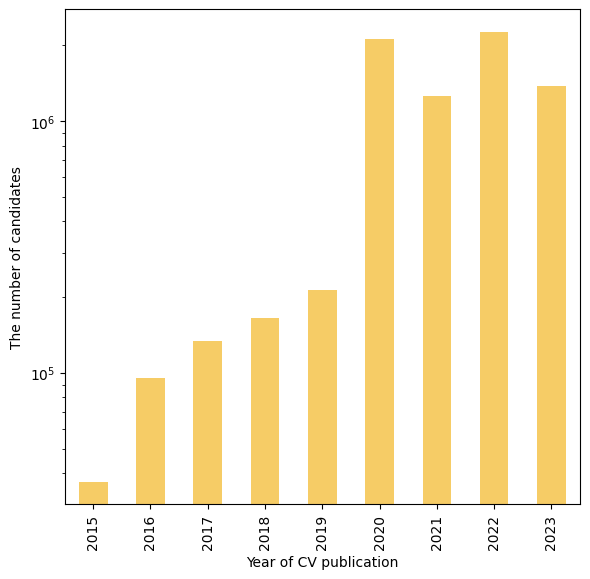

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cv.set_index('publish').plot.bar(ax=ax, legend=False, color=['#f6cc66ff'])
plt.xlabel('Year of CV publication')
plt.ylabel('The number of candidates')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
fig.savefig('Fig1-2.png', dpi=600)
plt.show()
del cv

In [41]:
age_groups = list(range(15, 90, 5))
dataset2['age_group'] = (2023 - pd.to_numeric(dataset2.birthyear)).apply(lambda x: age_groups[bisect.bisect(age_groups, x) - 1] if pd.notna(x) else x)
dataset2['gender'] = pd.to_numeric(dataset2['gender']).apply(lambda x: -1 if x == 0 else x)
pyramid = dataset2.drop_duplicates('id_candidate')[['gender', 'age_group', 'id_candidate']].dropna().groupby(['gender', 'age_group']).count().reset_index()
pyramid['id_candidate'] = pyramid['id_candidate'] * 100 / pyramid['id_candidate'].sum()
age_groups

[15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

In [10]:
dataset2['age'] = 2023 - pd.to_numeric(dataset2.birthyear)
dataset2['age'].dropna().median()

38.0

<ipython-input-42-d2db573ee2c3>:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 300x300 with 0 Axes>

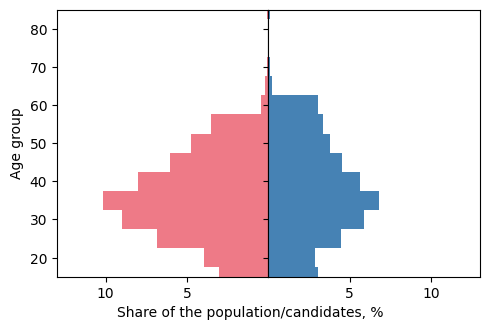

In [42]:
fig = plt.figure(figsize=(3, 3))
female = pyramid[pyramid.gender == -1]
male = pyramid[pyramid.gender == 1]
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(5, 3.5))
bar1 = axes[0].barh(y=female["age_group"], width=female["id_candidate"] * -1, align='center', height=5, color='#ee7a87')
bar2 = axes[1].barh(y=male["age_group"], width=male["id_candidate"], align='center', height=5, color='#4682b4')
axes[0].set_xlim([-13, -0.001])
axes[1].set_xlim([0.001, 13])
axes[0].set_xticklabels(labels=[15, 10, 5, 0, 5, 10, 15])
axes[0].set_xlabel('                                        Share of the population/candidates, %')
axes[0].set_ylabel('Age group')
plt.ylim(15, 85)
plt.tight_layout()
fig.subplots_adjust(wspace=0, top=0.93)
fig.savefig('Fig2-2.png', dpi=600)

<ipython-input-43-196551f6e4ee>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 300x300 with 0 Axes>

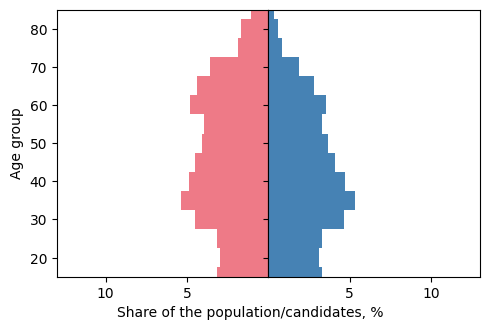

In [43]:
rf = pd.read_csv('./rostrud_pipeline/misc/rf-2023.csv', sep=',')
# https://www.populationpyramid.net/ru/%D1%80%D0%BE%D1%81%D1%81%D0%B8%D1%8F/2023/
rf['age_group'] = rf['Age'].apply(lambda x: int(x.split('-')[0]) if '+' not in x else np.nan)
rf = rf[(rf['age_group'] >= 15) & (rf['age_group'] <= 99)].dropna()
rf['male'] = rf['M'] * 100 / (rf['M'].sum() + rf['F'].sum())
rf['female'] = rf['F'] * 100 / (rf['M'].sum() + rf['F'].sum())
rf_female = rf[['female', 'age_group']]
rf_male = rf[['male', 'age_group']]

fig = plt.figure(figsize=(3, 3))
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(5, 3.5))
bar1 = axes[0].barh(y=rf_female["age_group"], width=rf_female["female"] * -1, align='center', height=5, color='#ee7a87')
bar2 = axes[1].barh(y=rf_male["age_group"], width=rf_male["male"], align='center', height=5, color='#4682b4')
axes[0].set_xlim([-13, -0.001])
axes[1].set_xlim([0.001, 13])
axes[0].set_xticklabels(labels=[15, 10, 5, 0, 5, 10, 15])
axes[0].set_xlabel('                                        Share of the population/candidates, %')
axes[0].set_ylabel('Age group')
plt.ylim(15, 85)
plt.tight_layout()
fig.subplots_adjust(wspace=0, top=0.93)
fig.savefig('Fig2-3.png', dpi=600)

In [8]:
dataset2['region'] = dataset2.region_code.apply(lambda x: x[:2] if pd.notna(x) else np.nan)
dataset2['region'] = dataset2.region.apply(lambda x: x.split(',')[0] if pd.notna(x) and ',' in x else x)
dataset2['region'] = dataset2.region.apply(lambda x: str(x).zfill(2) if pd.notna(x) else x)
dataset2['region'].value_counts()

region
23    337742
50    312652
05    277263
78    263713
66    235259
       ...  
83      4710
87      1651
99      1026
95        30
90        19
Name: count, Length: 86, dtype: int64

In [13]:
r = dataset2['region'].value_counts()
r = (r * 100 / r.sum()).rename('n')
reg = pd.read_csv("./rostrud_pipeline/misc/region_code_short.csv")
reg['region_code'] = reg['region_code'].apply(lambda x: str(str(x)[:2]).zfill(2))
r = reg.set_index('region_code').join(r)
regions = pd.read_parquet("offline_russia_plotly/data/russia_regions.parquet")
regions.loc[regions["region"] == "Ханты-Мансийский автономный округ — Югра", 'region'] = "Ханты-Мансийский автономный округ - Югра"
regions.loc[regions["region"] == "Республика Северная Осетия — Алания", 'region'] = "Республика Северная Осетия-Алания"
regions.loc[regions["region"] == "Москва", 'region'] = "г. Москва"
regions.loc[regions["region"] == "Санкт-Петербург", 'region'] = "г. Санкт-Петербург"
regions = regions.set_index('region').join(r.set_index('region_name'))
regions = regions[pd.notna(regions.n)].reset_index()
russia_map = mapFigure(regions=regions)
russia_map.show()
russia_map.write_image("Fig1-4.png", format="png", engine='kaleido', width=1000, height=1000)

In [14]:
r.n.min()

0.0133906092936049

In [15]:
r.n.max()

4.407964097505562

In [19]:
cv = dataset2[['id_candidate', 'date_publish']].copy()
cv['date_publish'] = pd.to_datetime(cv['date_publish'])
cv = cv.set_index('date_publish').resample('M').count().reset_index()

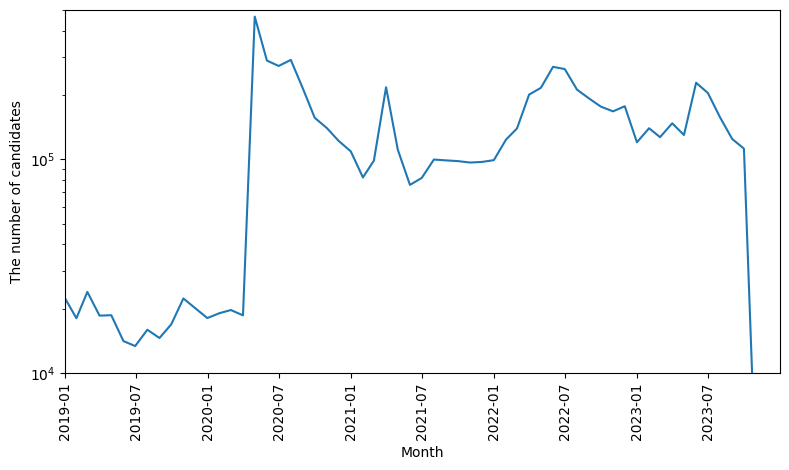

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv['date_publish'], cv['id_candidate'])
ax.set_xlim([dt.datetime(2019, 1, 1), dt.datetime(2023, 12, 31)])
ax.set_ylim([10000, 500000])
#ax.xaxis.set_major_locator(plticker.MultipleLocator(base=31.0))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
#ax.set_xticklabels([x.strftime('%Y-%m') for x in cv['date_publish']])
plt.xlabel('Month')
plt.ylabel('The number of candidates')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
fig.subplots_adjust(wspace=0, top=0.93)
plt.show()
fig.savefig('Fig3.png', dpi=600)
#del cv

In [21]:
cv = dataset2[['id_candidate', 'date_publish', 'cluster']].copy()
cv['date_publish'] = pd.to_datetime(cv['date_publish'])
cv1 = cv[cv.cluster == '0'].set_index('date_publish').resample('M').count().reset_index()
cv2 = cv[cv.cluster == '1'].set_index('date_publish').resample('M').count().reset_index()

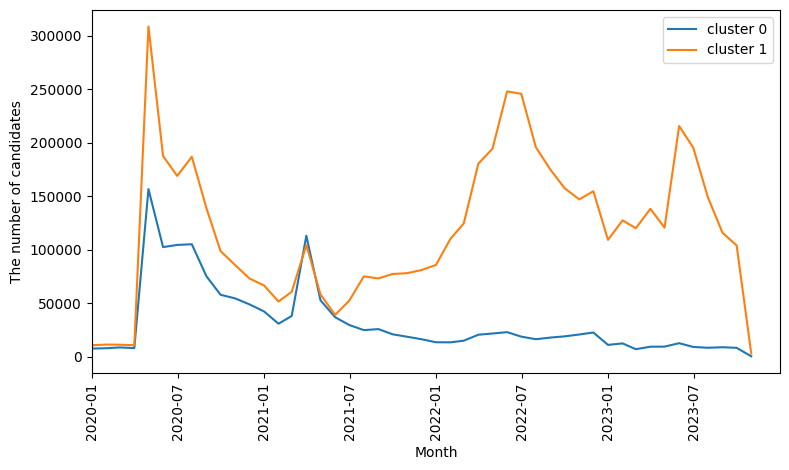

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(cv1['date_publish'], cv1['id_candidate'], label='cluster 0')
ax.plot(cv2['date_publish'], cv2['id_candidate'], label='cluster 1')
ax.set_xlim([dt.datetime(2020, 1, 1), dt.datetime(2023, 12, 31)])
plt.xlabel('Month')
plt.ylabel('The number of candidates')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
fig.subplots_adjust(wspace=0, top=0.93)
plt.show()
fig.savefig('Fig4.png', dpi=600)
#del cv1, cv2

### Dataset 1

In [24]:
cand = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.cand.csv.zip', sep='|', compression='zip', dtype=str)

In [ ]:
cand.columns

Index(['id_candidate', 'date_modify_inner_info', 'position_name', 'salary',
       'gender', 'birthyear', 'region_code'],
      dtype='object')

In [ ]:
cand.head()

id_candidate date_modify_inner_info  \
0  57eda7f0-82d1-11ea-8503-037acc02728d             2022-02-03   
1  57edaac0-be2e-11ed-925f-732207d240c8             2023-03-09   
2  57edabd0-b9e3-11ea-82e7-03fd6b4dc11f             2022-01-28   
3  57edac10-f8be-11ea-a1ca-7bf9d8e248ac             2022-05-23   
4  57edaee0-2c16-11ec-ba71-435dcfab4560             2022-01-01   

                      position_name salary gender birthyear region_code  
0        Администратор, экскурсовод  35000      0      1988          22  
1                  Кухонный рабочий  26000    NaN       NaN          24  
2         Водитель камаза, Водитель  50000      1      2000          64  
3  Секретарь, Помощник руководителя  25000      0      1989          24  
4                           Инженер  30000      0      1992          86

In [ ]:
cand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221439 entries, 0 to 6221438
Data columns (total 7 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   id_candidate            object
 1   date_modify_inner_info  object
 2   position_name           object
 3   salary                  object
 4   gender                  object
 5   birthyear               object
 6   region_code             object
dtypes: object(7)
memory usage: 332.3+ MB


In [ ]:
cand.id_candidate.drop_duplicates().count()

6221439

In [ ]:
cand.date_modify_inner_info.dropna().min()

'2015-04-23'

In [ ]:
cand.date_modify_inner_info.dropna().max()

'2023-10-03'

In [ ]:
pd.to_numeric(cand.gender).sum() * 100 / len(cand)
# 1 - male

36.88368559106663

In [ ]:
cand['age'] = 2023 - pd.to_numeric(cand.birthyear)
cand['age'].dropna().median()

38.0

In [25]:
cand['region'] = cand.region_code.apply(lambda x: x[:2] if pd.notna(x) else np.nan)
cand['region'] = cand.region.apply(lambda x: x.split(',')[0] if pd.notna(x) and ',' in x else x)
cand['region'] = cand.region.apply(lambda x: str(x).zfill(2) if pd.notna(x) else x)
cand['region'].value_counts()

region
50    277518
23    259228
05    232778
78    224054
77    221900
       ...  
83      2874
87      1244
99       729
95        26
90        14
Name: count, Length: 86, dtype: int64

In [26]:
cand.salary.median()

30000.0

In [27]:
cv = cand[['id_candidate', 'date_modify_inner_info']].copy()
cv['date_publish'] = pd.to_datetime(cv['date_modify_inner_info'])
cv = cv.reset_index().set_index('date_publish').resample('Y').count().reset_index().rename(columns={'date_publish':'publish'})
cv['publish'] = cv['publish'].apply(lambda x: int(str(x).split('-')[0]))

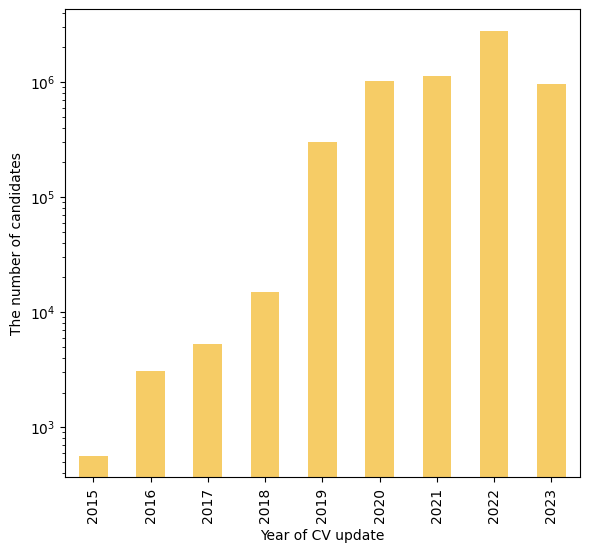

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cv.set_index('publish').plot.bar(ax=ax, legend=False, color=['#f6cc66ff'])
plt.xlabel('Year of CV update')
plt.ylabel('The number of candidates')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
fig.subplots_adjust(wspace=0, top=0.93)
plt.show()
fig.savefig('Fig1-1.png', dpi=600)
#del cv

In [29]:
age_groups = list(range(15, 90, 5))
cand['age_group'] = (2023 - pd.to_numeric(cand.birthyear)).apply(lambda x: age_groups[bisect.bisect(age_groups, x) - 1] if pd.notna(x) else x)
cand['gender'] = pd.to_numeric(cand['gender']).apply(lambda x: -1 if x == 0 else x)
pyramid = cand.drop_duplicates('id_candidate')[['gender', 'age_group', 'id_candidate']].dropna().groupby(['gender', 'age_group']).count().reset_index()
pyramid['id_candidate'] = pyramid['id_candidate'] * 100 / pyramid['id_candidate'].sum()
age_groups

[15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

<ipython-input-34-5e6cce963738>:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 300x300 with 0 Axes>

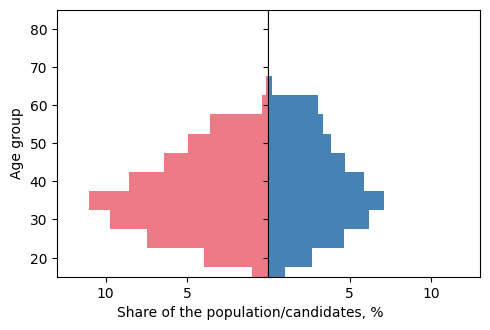

In [34]:
fig = plt.figure(figsize=(3, 3))
female = pyramid[pyramid.gender == -1]
male = pyramid[pyramid.gender == 1]
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(5, 3.5))
bar1 = axes[0].barh(y=female["age_group"], width=female["id_candidate"] * -1, align='center', height=5, color='#ee7a87')
bar2 = axes[1].barh(y=male["age_group"], width=male["id_candidate"], align='center', height=5, color='#4682b4')
axes[0].set_xlim([-13, -0.001])
axes[1].set_xlim([0.001, 13])
axes[0].set_xticklabels(labels=[15, 10, 5, 0, 5, 10, 15])
axes[0].set_xlabel('                                        Share of the population/candidates, %')
axes[0].set_ylabel('Age group')
plt.ylim(15, 85)
plt.tight_layout()
fig.subplots_adjust(wspace=0, top=0.93)
fig.savefig('Fig2-1.png', dpi=600)

In [37]:
reg = pd.read_csv("./rostrud_pipeline/misc/region_code_short.csv")
reg['region_code'] = reg['region_code'].apply(lambda x: str(str(x)[:2]).zfill(2))
regions = pd.read_parquet("offline_russia_plotly/data/russia_regions.parquet")
regions.loc[regions["region"] == "Ханты-Мансийский автономный округ — Югра", 'region'] = "Ханты-Мансийский автономный округ - Югра"
regions.loc[regions["region"] == "Республика Северная Осетия — Алания", 'region'] = "Республика Северная Осетия-Алания"
regions.loc[regions["region"] == "Москва", 'region'] = "г. Москва"
regions.loc[regions["region"] == "Санкт-Петербург", 'region'] = "г. Санкт-Петербург"
r = cand.region.value_counts()
r = (r * 100 / r.sum()).rename('n')
r = reg.set_index('region_code').join(r)
regions = regions.set_index('region').join(r.set_index('region_name'))
regions = regions[pd.notna(regions.n)].reset_index()
russia_map = mapFigure(regions=regions)
russia_map.show()
russia_map.write_image("Fig1-3.png", format="png", engine='kaleido', width=1000, height=1000)

In [38]:
r.n.min()

0.011717552024966583

In [ ]:
r.n.max()

4.460674352352093

In [ ]:
edu = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.edu.csv.zip', sep='|', compression='zip', dtype=str)

In [ ]:
edu.columns

Index(['id_candidate', 'legal_name', 'graduate_year', 'faculty',
       'qualification', 'speciality', 'course_name'],
      dtype='object')

In [ ]:
pd.to_numeric(edu.graduate_year).min()

1953.0

In [ ]:
pd.to_numeric(edu.graduate_year).max()

2028.0

In [ ]:
edu.head()

id_candidate  \
0  00000240-8777-11ea-b730-3bfa22f2d66b   
1  00000350-da5c-11ec-aa25-8b73fce3b7f1   
2  00000d80-a245-11ed-9023-732207d240c8   
3  00000f80-b23b-11ea-ada6-7bf9d8e248ac   
4  00000f80-b23b-11ea-ada6-7bf9d8e248ac   

                                          legal_name graduate_year  \
0                                      Средняя школа          1990   
1             КАСУ Казахстанско-Американский колледж          2009   
2                                              Школа          1989   
3  Егорьевский Филиал Московский государственный ...          2025   
4      Куровская Средняя Общеобразовательная Школа 1          2006   

                    faculty qualification  \
0                       NaN           NaN   
1                 Финансист           NaN   
2                       NaN           NaN   
3  Информатики и математики           NaN   
4                       NaN           NaN   

                            speciality course_name  
0                                  NaN         NaN  
1                Финансы (по отраслям)         NaN  
2                                  NaN         NaN  
3  Прикладная информатика(в экономике)         NaN  
4                                  NaN         NaN

In [ ]:
workexp = pd.read_csv('/content/drive/MyDrive/tmp/dataset1.workexp.csv.zip', sep='|', compression='zip', dtype=str)

In [ ]:
workexp.columns

Index(['id_candidate', 'company_name', 'date_from', 'date_to', 'job_title'], dtype='object')

In [ ]:
pd.to_datetime(workexp.date_from).min()

Timestamp('1956-08-01 00:00:00')

In [ ]:
pd.to_datetime(workexp.date_from).max()

Timestamp('2023-12-30 00:00:00')

In [ ]:
pd.to_datetime(workexp.date_to).min()

Timestamp('1962-08-01 00:00:00')

In [ ]:
pd.to_datetime(workexp.date_to).max()

Timestamp('2024-01-01 00:00:00')

In [ ]:
workexp.head()

id_candidate                company_name  \
0  57eda7f0-82d1-11ea-8503-037acc02728d            ИП Кирюшкин А.В.   
1  57eda7f0-82d1-11ea-8503-037acc02728d      ООО Логистик ресторанс   
2  57edac10-f8be-11ea-a1ca-7bf9d8e248ac  ООО Планетамолл-Красноярск   
3  57edac10-f8be-11ea-a1ca-7bf9d8e248ac            ООО Сиб-АрПроект   
4  57edac10-f8be-11ea-a1ca-7bf9d8e248ac  ООО Планетамолл-Красноярск   

    date_from     date_to      job_title  
0  2012-04-01  2013-03-01         Кассир  
1  2012-01-01  2012-03-01       Оператор  
2  2019-09-01  2020-09-01  Администратор  
3  2008-09-01  2012-10-01      Секретарь  
4  2019-10-01  2020-09-01  Администратор